In [1]:
# Data handling and preprocessing
import pandas as pd
import numpy as np

# Machine learning models and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Handling imbalanced data (e.g., SMOTE)
from imblearn.over_sampling import SMOTE

# For handling missing data
from sklearn.impute import SimpleImputer

# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# Model selection and optimization
from sklearn.model_selection import GridSearchCV

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
transactions = pd.read_csv("transactions_data.csv")

In [3]:
transactions

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,$40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,$4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN


In [4]:
transactions.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')

In [5]:
# Load fraud labels
fraud_labels = pd.read_json('train_fraud_labels.json')

# Load MCC codes
import json
with open('mcc_codes.json', 'r') as f:
    mcc_codes = json.load(f)


In [6]:
print(fraud_labels.head())

         target
10649266     No
23410063     No
9316588      No
12478022     No
9558530      No


In [7]:
# Reset the index to make it a column
fraud_labels = fraud_labels.reset_index()

# Rename the columns
fraud_labels.columns = ['id', 'is_fraud']

# Verify the result
print(fraud_labels.head())


         id is_fraud
0  10649266       No
1  23410063       No
2   9316588       No
3  12478022       No
4   9558530       No


In [8]:
print(transactions.columns)
print(fraud_labels.columns)


Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')
Index(['id', 'is_fraud'], dtype='object')


In [9]:
# Remove the '$' sign and convert to float
transactions['amount'] = transactions['amount'].replace('[\$,]', '', regex=True).astype(float)


In [10]:
# Merge transactions with fraud labels
transactions = transactions.merge(fraud_labels, on='id', how='left')


print(transactions.head())


        id                 date  client_id  card_id  amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  -77.00   
1  7475328  2010-01-01 00:02:00        561     4575   14.57   
2  7475329  2010-01-01 00:02:00       1129      102   80.00   
3  7475331  2010-01-01 00:05:00        430     2860  200.00   
4  7475332  2010-01-01 00:06:00        848     3915   46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  errors is_fraud  
0    NaN       No  
1    NaN       No  
2    NaN       No  
3    NaN      NaN  
4    NaN       No  


In [11]:
transactions.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'is_fraud'],
      dtype='object')

In [12]:
# Drop unwanted columns
transactions = transactions.drop(columns=['id', 'date'])

transactions.columns

# Verify the result

Index(['client_id', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'is_fraud'],
      dtype='object')

In [13]:
# Replace 'yes' with 1 and 'no' with 0 in the 'is_fraud' column
transactions['is_fraud'] = transactions['is_fraud'].replace({'yes': 1, 'no': 0})

# Verify the changes
transactions['is_fraud'].head()


0     No
1     No
2     No
3    NaN
4     No
Name: is_fraud, dtype: object

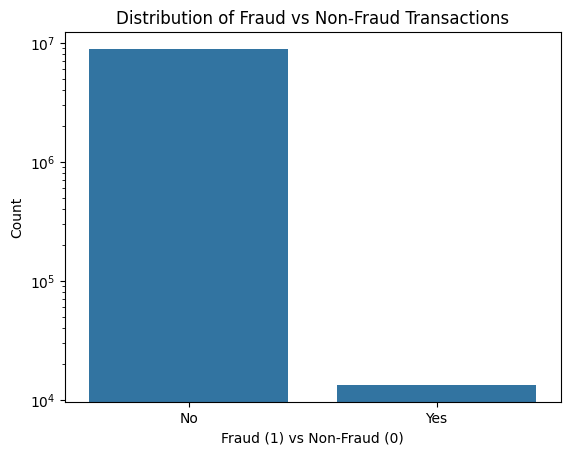

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the distribution of the target variable
sns.countplot(data=transactions, x='is_fraud')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Fraud (1) vs Non-Fraud (0)')
plt.ylabel('Count')
# Adjust y-axis to make the plot more readable
plt.yscale('log')  # Log scale helps with large differences in counts
plt.show()


In [15]:
# Count the number of fraud and non-fraud transactions
fraud_counts = transactions['is_fraud'].value_counts()
print(fraud_counts)


is_fraud
No     8901631
Yes      13332
Name: count, dtype: int64


In [16]:
transactions

,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,No
1,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,No
2,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,No
3,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,NaN
4,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
13305910,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN,No
13305911,1766,2066,12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN,No
13305912,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN,No
13305913,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN,NaN


In [17]:
# Drop rows where 'is_fraud' is NaN
transactions = transactions.dropna(subset=['is_fraud'])

# Verify the result
print(transactions['is_fraud'].isna().sum())  # This should return 0, indicating no NaN values


0


In [18]:
transactions

,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,No
1,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,No
2,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,No
4,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,No
5,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
13305905,672,5001,12.93,Chip Transaction,47508,Cosby,TN,37722.0,7230,NaN,No
13305906,1384,3723,67.01,Chip Transaction,58136,Williamson,GA,30292.0,5812,NaN,No
13305910,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN,No
13305911,1766,2066,12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN,No


In [19]:
transactions.columns


Index(['client_id', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'is_fraud'],
      dtype='object')

In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
categorical_columns = ['use_chip', 'merchant_city', 'merchant_state', 'errors']
for col in categorical_columns:
    transactions[col] = label_encoder.fit_transform(transactions[col])

# Now, the 'use_chip' and other columns should be encoded as numeric values


/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_10963/4062495942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[col] = label_encoder.fit_transform(transactions[col])
/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_10963/4062495942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[col] = label_encoder.fit_transform(transactions[col])
/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_10963/4062495942.py:9: SettingWithCopyWarning: 
A value is tryi

In [21]:
# Separate columns based on data types
numeric_columns = transactions.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = transactions.select_dtypes(include=['object']).columns

# Check the columns
print(numeric_columns)
print(categorical_columns)


Index(['client_id', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors'],
      dtype='object')
Index(['is_fraud'], dtype='object')


In [22]:
from sklearn.impute import SimpleImputer

# Impute missing values in numeric columns using the mean
numeric_imputer = SimpleImputer(strategy='mean')
transactions[numeric_columns] = numeric_imputer.fit_transform(transactions[numeric_columns])


/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_10963/4205786619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[numeric_columns] = numeric_imputer.fit_transform(transactions[numeric_columns])


In [23]:
# Impute missing values in categorical columns using the mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
transactions[categorical_columns] = categorical_imputer.fit_transform(transactions[categorical_columns])


/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_10963/315866799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[categorical_columns] = categorical_imputer.fit_transform(transactions[categorical_columns])


In [24]:
# Apply one-hot encoding to categorical columns
transactions = pd.get_dummies(transactions, columns=categorical_columns, drop_first=True)


In [25]:
# Check the final dataset
print(transactions.isnull().sum())  # Ensure no missing values
print(transactions.dtypes)  # Ensure all columns are numeric


client_id         0
card_id           0
amount            0
use_chip          0
merchant_id       0
merchant_city     0
merchant_state    0
zip               0
mcc               0
errors            0
is_fraud_Yes      0
dtype: int64
client_id         float64
card_id           float64
amount            float64
use_chip          float64
merchant_id       float64
merchant_city     float64
merchant_state    float64
zip               float64
mcc               float64
errors            float64
is_fraud_Yes         bool
dtype: object


In [26]:
# Separate features (X) and target (y)
X = transactions.drop(columns=['is_fraud_Yes'])  # Drop the 'is_fraud_Yes' column, which is now the target
y = transactions['is_fraud_Yes']  # The target is now in 'is_fraud_Yes'


# Apply PCA to reduce dimensionality (e.g., to 10 components)
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Convert back to a DataFrame
transactions_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
transactions_pca['is_fraud'] = y


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# 1. Separate features (X) and target (y)
X = transactions.drop(columns=['is_fraud_Yes'])  # Remove the target column
y = transactions['is_fraud_Yes']

In [28]:
# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=330)


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=330, class_weight='balanced')
rf_model.fit(X_train, y_train)


In [ ]:
# 4. Make predictions
y_pred = rf_model.predict(X_test)

In [ ]:
# 5. Evaluate model performance
print(classification_report(y_test, y_pred))


In [ ]:
print(len(rf_model.estimators_))  # Should print a number > 0


In [ ]:
transactions.columns

In [ ]:
fraud_cases = transactions[transactions['is_fraud_Yes'] == 1]


In [ ]:
legit_cases = transactions[transactions['is_fraud_Yes'] == 0].sample(
    n=len(fraud_cases) * 20,  # Ratio of 20x
    random_state=42
)


In [ ]:
fraud_cases

In [ ]:
legit_cases

In [ ]:
balanced_data = pd.concat([fraud_cases, legit_cases], axis=0).sample(frac=1, random_state=330)


In [ ]:
from sklearn.model_selection import train_test_split

X_balanced = balanced_data.drop(columns=['is_fraud_Yes'])
y_balanced = balanced_data['is_fraud_Yes']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=330
)


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=330)

X_resampled_bal, y_resampled_bal = smote.fit_resample(X_train_bal, y_train_bal)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight= 'balanced')
rf_model.fit(X_resampled_bal, y_resampled_bal)


In [ ]:
from sklearn.metrics import classification_report

y_pred_bal = rf_model.predict(X_test_bal)
print(classification_report(y_test_bal, y_pred_bal))


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier (AUC = 0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(10))


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=330)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# AUC scores from cross-validation
auc_scores = [0.98011065, 0.98029356, 0.98027004, 0.97999971, 0.98001727]

# Calculate the mean AUC
mean_auc = np.mean(auc_scores)

# Plotting the AUC scores for each fold
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(auc_scores) + 1), auc_scores, marker='o', linestyle='-', color='b', label='AUC per fold')

# Adding mean AUC line
plt.axhline(mean_auc, color='r', linestyle='--', label=f'Mean AUC: {mean_auc:.4f}')

# Adding labels and title
plt.title('Cross-Validation AUC Scores')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid(True)

# Display the plot
plt.show()
